In [35]:
cd '/mmfs1/data/aglinska/BC-MRI-AE/Colab Notebooks/'

/mmfs1/data/aglinska/BC-MRI-AE/Colab Notebooks


In [36]:
import pickle

import numpy as np
import pandas as pd 

from importlib import reload

import helper_funcs;reload(helper_funcs);from helper_funcs import *
import make_models;reload(make_models);from make_models import *

from functools import partial
from sklearn.decomposition import PCA
import scipy
from matplotlib import pyplot as plt
from sklearn.mixture import BayesianGaussianMixture as bnpc

import shutil
from functools import partial
from tqdm import tqdm
tqdm = partial(tqdm, position=0, leave=True)

In [37]:
%%time 
import ants

CPU times: user 7 µs, sys: 3 µs, total: 10 µs
Wall time: 18.1 µs


In [38]:
# LOAD ABIDE DATA
dataFnOut = '/mmfs1/data/aglinska/BC-MRI-AE/Data/ABIDE-Anat-64iso-S982.npz'
dfFnOut = '/mmfs1/data/aglinska/BC-MRI-AE/Data/ABIDE_legend_S982.csv'

ABIDE_data = np.load(dataFnOut)['data']
df = pd.read_csv(dfFnOut)

patients = df['DxGroup'].values==1
controls = df['DxGroup'].values==2
abide_asd = ABIDE_data[patients,:,:,:]

  0%|          | 0/10 [00:23<?, ?it/s]


In [39]:
# LOAD SFARI 
arr = np.load('../Data/SFARI-Anat-64iso-S121.npz')
dfs = pd.read_csv('../Data/sfari_legend_S121.csv')

SFARI_data = arr['data']
SFARI_subs = arr['subs']

sfari_subs_td = dfs['family_type'].values=='non-familial-control'
sfari_subs_dupl = dfs['family_type'].values=='16p-duplication'
sfari_subs_del = dfs['family_type'].values=='16p-deletion'

In [40]:
# LOAD VAE
latent_dim=32;batch_size=64;disentangle=False;gamma=1
encoder, decoder, vae = get_MRI_VAE_3D(input_shape=(64, 64, 64, 1), latent_dim=latent_dim, batch_size=batch_size, disentangle=disentangle, gamma=gamma)
fn = '/mmfs1/data/aglinska/tf_outputs/VAE/Jan12th_16d'

loss = list()
print('ready')
if os.path.exists(fn+'_loss.pickle'):
    print('loading')
    vae.load_weights(fn)
    loss = pickle.load(open(fn+'_loss.pickle','rb'))

  0%|          | 0/10 [02:35<?, ?it/s]


ready
loading


In [41]:
# LOAD CVAE
latent_dim = 16;batch_size = 32;beta = 1;gamma = 100;disentangle = True
cvae, z_encoder, s_encoder, cvae_decoder = get_MRI_CCVAE_3D(latent_dim=latent_dim,beta=beta, disentangle=disentangle, gamma=gamma, bias=True, batch_size = batch_size)

fn = '/mmfs1/data/aglinska/tf_outputs/CVAE/Feb23_1551_D16B1G100_DTrue'
loss = pickle.load(open(fn+'_loss.pickle','rb'))
cvae.load_weights(fn)

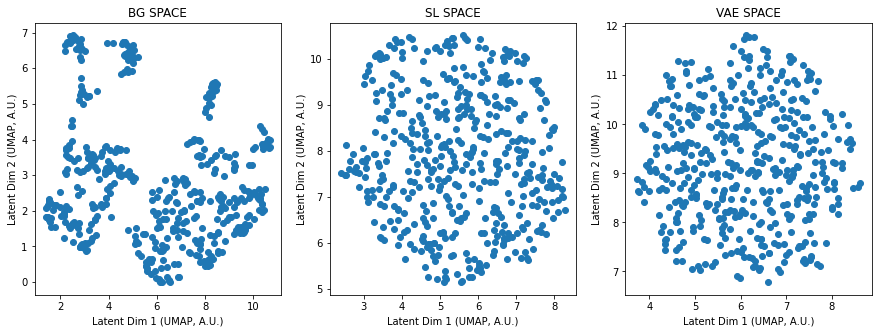

In [42]:
ofdir = '/mmfs1/data/aglinska/BC-MRI-AE/Data/'
embedded_data = pickle.load(open(os.path.join(ofdir,'embedded_data.pickle'),'rb'))

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.scatter(embedded_data['bg_space_abide'][:,0],embedded_data['bg_space_abide'][:,1])
#plt.scatter(bg_space_sfari[:,0],bg_space_sfari[:,1])
#plt.legend(['ABIDE','SFARI']);
plt.title('BG SPACE')
plt.xlabel('Latent Dim 1 (UMAP, A.U.)')
plt.ylabel('Latent Dim 2 (UMAP, A.U.)')

plt.subplot(1,3,2)
plt.scatter(embedded_data['sl_space_abide'][:,0],embedded_data['sl_space_abide'][:,1])
#plt.scatter(sl_space_sfari[:,0],sl_space_sfari[:,1])
#plt.legend(['ABIDE','SFARI']);
plt.title('SL SPACE')
plt.xlabel('Latent Dim 1 (UMAP, A.U.)')
plt.ylabel('Latent Dim 2 (UMAP, A.U.)')

plt.subplot(1,3,3)
plt.scatter(embedded_data['vae_space_abide'][:,0],embedded_data['vae_space_abide'][:,1])
#plt.scatter(vae_space_sfari[:,0],vae_space_sfari[:,1])
plt.xlabel('Latent Dim 1 (UMAP, A.U.)')
plt.ylabel('Latent Dim 2 (UMAP, A.U.)')
#plt.legend(['ABIDE','SFARI']);
plt.title('VAE SPACE')
plt.savefig('/mmfs1/data/aglinska/figures/spaces_abide.png',dpi=300)

In [43]:
def inverse_tx_umap(targ,s_embedding):
    targ = np.array(targ)
    idx = np.argsort(((s_embedding-targ)**2).sum(axis=1))
    return idx

def get_umap_corners(s_embedding):
    ax_min = s_embedding.min(axis=0)
    ax_max = s_embedding.max(axis=0)
    ax_mid = s_embedding.mean(axis=0)
    
#     ll = inverse_tx_umap((ax_min[0],ax_min[1]),s_embedding)
#     lr = inverse_tx_umap((ax_max[0],ax_min[1]),s_embedding)
#     tl = inverse_tx_umap((ax_min[0],ax_max[1]),s_embedding)
#     tr = inverse_tx_umap((ax_max[0],ax_max[1]),s_embedding)

    L = inverse_tx_umap((ax_min[0],ax_mid[1]),s_embedding)
    R = inverse_tx_umap((ax_max[0],ax_mid[1]),s_embedding)
    T = inverse_tx_umap((ax_mid[0],ax_max[1]),s_embedding)
    B = inverse_tx_umap((ax_mid[0],ax_min[1]),s_embedding)
    
    cntr = inverse_tx_umap(s_embedding.mean(axis=0),s_embedding)
    
    map_ = dict()
#     map_['ll'] = ll
#     map_['lr'] = lr
#     map_['tr'] = tr
#     map_['tl'] = tl

    map_['L'] = L
    map_['R'] = R
    map_['T'] = T
    map_['B'] = B
    map_['center'] = cntr

    return map_

def get_brain_pair(b_vec,s_vec):
    
    vec_asd = np.hstack((b_vec,s_vec))
    vec_td = np.hstack((b_vec,np.zeros(16)))

    im_asd = cvae_decoder.predict(np.vstack((vec_asd,vec_asd)))[0,:,:,:,0]
    im_td = cvae_decoder.predict(np.vstack((vec_td,vec_td)))[0,:,:,:,0]
    
    thresh = 0.0
    im_asd[im_asd<thresh]=0
    im_td[im_td<thresh]=0
    
    nii_asd = template.new_image_like(im_asd)
    nii_td = template.new_image_like(im_td)
    
    nii_asd.set_origin(tuple(np.array(nii_asd.origin)-np.array(nii_asd.get_center_of_mass())))
    nii_td.set_origin(tuple(np.array(nii_asd.origin)-np.array(nii_asd.get_center_of_mass())))
    
    return nii_td,nii_asd

def clean_tx_folder(tx):
    [os.remove(f) for f in np.unique(np.vstack((np.array(tx['fwdtransforms']),np.array(tx['invtransforms']))))];

In [44]:
template = ants.image_read('/mmfs1/data/aglinska/BC-ASD-FC/Atlas/Atlas_brain_2mm.nii')
template = ants.resample_image(template,(64,64,64),use_voxels=True,interp_type=4)

In [45]:
map_ = get_umap_corners(s_embedding)

In [46]:
def get_data(corner,idx,do_plot,normalize):
# 
# do_plot = True;normalize=False
    idx = map_[corner][idx]
    nii_td,nii_asd = get_brain_pair(space_bg[idx,:],space_sl[idx,:])

    if do_plot:
        nii_asd.plot_ortho((nii_td),overlay_alpha=.3,flat=True,title='TD and ASD sampled')

    outdir = '/data/aglinska/txs/'

    tx = ants.registration(fixed=nii_asd,moving=nii_td,type_of_transform='Rigid',outprefix=outdir)
    nii_td = ants.apply_transforms(fixed=nii_asd,moving=nii_td,transformlist=tx['fwdtransforms'],interpolator='bSpline')


    #clean_tx_folder(tx)

    if do_plot:
        nii_asd.plot_ortho((nii_td),overlay_alpha=.3,flat=True,title='TD and ASD rigid aligned')

    if normalize:
        
#        native_asd = nii_asd.copy()
#        native_td = nii_asd.copy()

        templateTiny = template.resample_image((64,64,64), use_voxels=True, interp_type=4)
        templateTiny.set_origin(tuple(np.array(templateTiny.origin)-np.array(templateTiny.get_center_of_mass())))

        if do_plot:
            templateTiny.plot_ortho(overlay=nii_asd,overlay_alpha=.3,flat=True,title='template overlay asd')

        txR2T = ants.registration(fixed=templateTiny,moving=nii_td,type_of_transform='Rigid',outprefix=outdir)
        nii_td = ants.apply_transforms(fixed=templateTiny,moving=nii_td,transformlist=txR2T['fwdtransforms'],interpolator='bSpline')
        nii_asd = ants.apply_transforms(fixed=templateTiny,moving=nii_asd,transformlist=txR2T['fwdtransforms'],interpolator='bSpline')

        if do_plot:
            templateTiny.plot_ortho(overlay=nii_td,overlay_alpha=.3,flat=True,title='template overlay ASD rigid')

        txNorm = ants.registration(fixed=templateTiny,moving=nii_asd,type_of_transform='SyN',outprefix=outdir)
        nii_td = ants.apply_transforms(fixed=templateTiny,moving=nii_td,transformlist=txNorm['fwdtransforms'],interpolator='bSpline')
        nii_asd = ants.apply_transforms(fixed=templateTiny,moving=nii_asd,transformlist=txNorm['fwdtransforms'],interpolator='bSpline')

        if do_plot:
            templateTiny.plot_ortho((nii_asd),overlay_alpha=.3,flat=True,title='template overlay ASD SyN')


    # WARP TD INTO ASD
    txT2A = ants.registration(fixed=nii_asd,moving=nii_td,type_of_transform='SyN',outprefix=outdir)

    # WANT JACOBIANS?
    J = ants.create_jacobian_determinant_image(nii_td,txT2A['fwdtransforms'][0])
    J1 = ants.create_jacobian_determinant_image(nii_td,txT2A['invtransforms'][1])

    # LOAD WARP as an image
    nii_tx = ants.image_read(txT2A['fwdtransforms'][0])

    if do_plot:
        (nii_asd-nii_td).plot_ortho(title='nii_asd-nii_td',flat=True)
    
    # CLEAN UP
    [os.remove(os.path.join(outdir,file)) for file in os.listdir(outdir)];

    #nii_td.to_filename('/mmfs1/data/aglinska/ims/nii_td.nii')
    #nii_asd.to_filename('/mmfs1/data/aglinska/ims/nii_asd.nii')
    #nii_tx.to_filename('/mmfs1/data/aglinska/ims/nii_tx.nii')
    
    data = {'nii_td' : nii_td, 'nii_asd' : nii_asd, 'J' : J, 'J1' : J1, 'nii_tx' : nii_tx}
    
    return data

In [47]:
#get_data('ll',0,do_plot=True,normalize=False):

In [48]:
def f(x,y,z):
    ''' return transformed coordinates'''
    i,j,k = np.array([x,y,z])+nii_tx.numpy()[x,y,z,:]
    return i,j,k

In [49]:
def get_C(x,y,z):
    J = np.zeros((3,3))
    J[:,0] = np.array(f(x,y,z))-np.array(f(x+1,y,z))
    J[:,1] = np.array(f(x,y,z))-np.array(f(x,y+1,z))
    J[:,2] = np.array(f(x,y,z))-np.array(f(x,y,z+1))
    
    C = np.matmul(J.transpose(),J)-np.eye(3)
    return C

In [50]:
# mat = np.zeros((64,64,64))
# xs,ys,zs = np.nonzero(nii_asd.get_mask().numpy()==1)

# for i in tqdm(range(len(xs))):
#     mat[xs[i],ys[i],zs[i]] = np.linalg.norm(get_C(xs[i],ys[i],zs[i]))

In [51]:
# mat = np.zeros((64,64,64,3,3))
# xs,ys,zs = np.nonzero(nii_asd.get_mask().numpy()==1)
# for i in tqdm(range(len(xs))):
#     mat[xs[i],ys[i],zs[i],:,:] = get_C(xs[i],ys[i],zs[i])

In [132]:
# green = nii_asd.new_image_like(mat)
# nii_tx.to_filename('/mmfs1/data/aglinska/ims/green.nii')
# greenT = green.copy()
# greenT[greenT<1.5]=0

In [52]:
# J1[abs(J1.numpy()-1)<.1]=0

In [53]:
# if normalize:
#     #templateTiny.plot_ortho(greenT,overlay_alpha=.5,flat=True)
#     #templateTiny.plot_ortho(J,overlay_alpha=.5,flat=True)
#     #templateTiny.plot_ortho(J1,overlay_alpha=.5,flat=True)
#     nii_asd.plot_ortho(flat=True,title='ASD')
#     nii_td.plot_ortho(flat=True,title='TD')
#     nii_td.plot_ortho(J1,overlay_alpha=.3,flat=True,overlay_cmap='bwr')
#     nii_td.plot_ortho(nii_asd,flat=True,overlay_alpha=.5)
# else:
#     nii_asd.plot_ortho(flat=True,title='ASD')
#     nii_td.plot_ortho(flat=True,title='TD')
#     nii_td.plot_ortho(J1,overlay_alpha=.3,flat=True,overlay_cmap='bwr')
#     nii_td.plot_ortho(nii_asd,flat=True,overlay_alpha=.5)

In [54]:
nsamples = 10

In [63]:
space_bg = embedded_data['embedding_bg']
space_sl = embedded_data['embedding_sl']

In [56]:
# ll = [get_data('ll',i,do_plot=False,normalize=True) for i in tqdm(range(nsamples))]
# lr = [get_data('lr',i,do_plot=False,normalize=True) for i in tqdm(range(nsamples))]
# tr = [get_data('tr',i,do_plot=False,normalize=True) for i in tqdm(range(nsamples))]
# tl = [get_data('tl',i,do_plot=False,normalize=True) for i in tqdm(range(nsamples))]
# #cntr_ = [get_data('center',i,do_plot=False,normalize=True) for i in tqdm(range(nsamples))]

In [66]:
nsamples = 10
L = [get_data('L',i,do_plot=False,normalize=True) for i in tqdm(range(nsamples))]
R = [get_data('R',i,do_plot=False,normalize=True) for i in tqdm(range(nsamples))]
T = [get_data('T',i,do_plot=False,normalize=True) for i in tqdm(range(nsamples))]
B = [get_data('B',i,do_plot=False,normalize=True) for i in tqdm(range(nsamples))]
cntr_ = [get_data('center',i,do_plot=False,normalize=True) for i in tqdm(range(nsamples))]

100%|██████████| 10/10 [00:39<00:00,  3.90s/it]


In [67]:
outside = template.get_mask().numpy().flatten()==0

In [386]:
#template.to_filename(f'/mmfs1/data/aglinska/ims/template.nii')

In [69]:
from scipy.stats import ttest_1samp

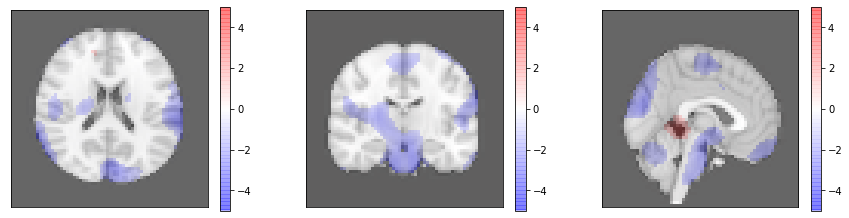

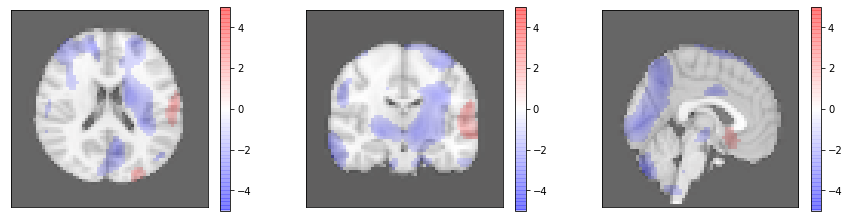

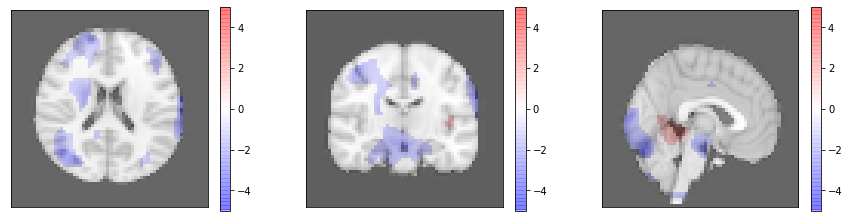

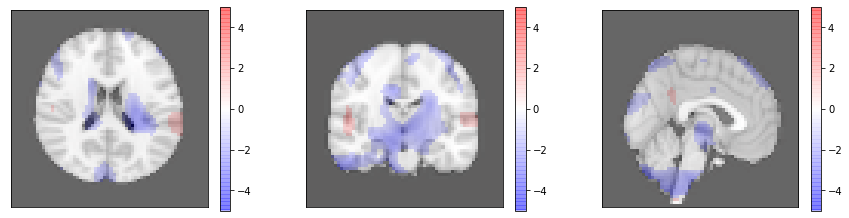

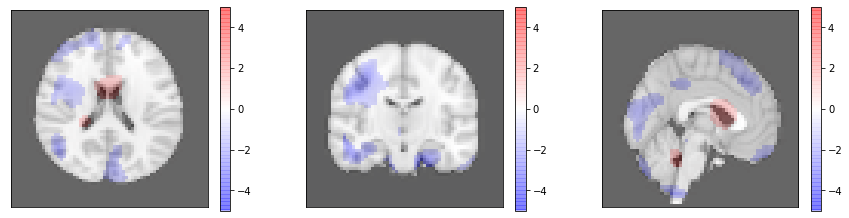

In [115]:
c = 10
#for mat in [ll,lr,tl,tr,cntr_]:
res = list()
for mat in [L,R,T,B,cntr_]:
    c+=1
    clim = (None,None)
    clim = (-5,5)
    
    arr = np.array([l['J1'].numpy() for l in mat])-1
    arr = arr.reshape(nsamples,-1)

    #tmat = arr.mean(axis=0) / (arr.std(axis=0)+1)

    tmat = ttest_1samp(arr,0)[0]
    tmat[np.isnan(tmat)]=0
    tmat[abs(tmat)<2.2]=0
    tmat[outside] = 0

    im = template
    ol = template.new_image_like(tmat.reshape(64,64,64))
    res.append(ol)
    plot_ortho(im,ol,i=32,j=32,k=32,clim=clim)
    
    #ol.to_filename(f'/mmfs1/data/aglinska/ims/newJ{c}.nii')

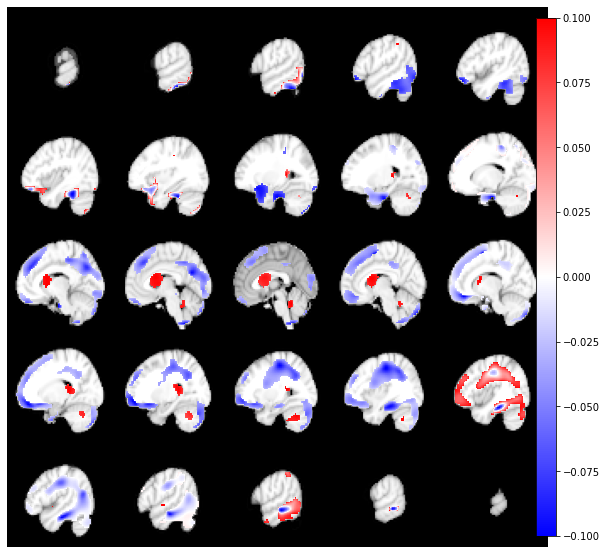

In [113]:
im.plot(res[4],nslices=25,overlay_alpha=1,cbar=True,overlay_cmap='bwr',scale=True)

In [110]:
res[4].numpy().flatten()

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [450]:
# data = get_data('ll',0,do_plot=False,normalize=True)
# data['nii_td'].plot_ortho(flat=True)
# data['nii_asd'].plot_ortho(flat=True)
# data['nii_td'].plot_ortho(data['J1'],flat=True,overlay_alpha=.3)
# data['nii_td'].plot(data['J1'],overlay_alpha=.3,nslices=25)

In [451]:
data = SFARI_data[(sfari_subs_del),:,:,:]
space_sl = s_encoder.predict(data)[w]
space_bg = z_encoder.predict(data)[w]

reducer = umap.UMAP(n_components=2)
s_embedding = reducer.fit_transform(space_sl)

del_16p = [get_data('center',i,do_plot=False,normalize=True) for i in tqdm(range(nsamples))]


data = SFARI_data[(sfari_subs_dupl),:,:,:]
space_sl = s_encoder.predict(data)[w]
space_bg = z_encoder.predict(data)[w]

reducer = umap.UMAP(n_components=2)
s_embedding = reducer.fit_transform(space_sl)

dupl_16p = [get_data('center',i,do_plot=False,normalize=True) for i in tqdm(range(nsamples))]

100%|██████████| 10/10 [00:38<00:00,  3.87s/it]


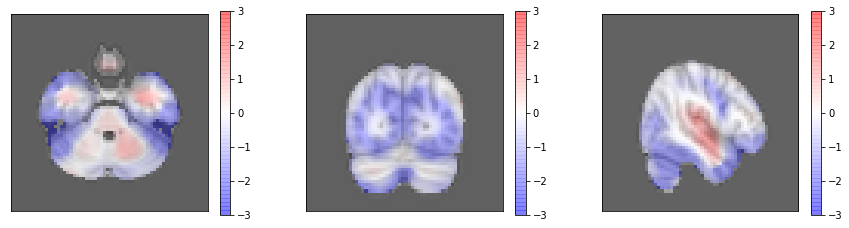

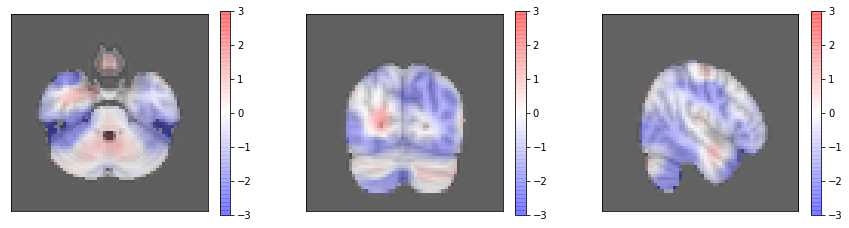

In [457]:
c = 10
#for mat in [ll,lr,tl,tr,cntr_]:
for mat in [del_16p,dupl_16p]:
    c+=1
    clim = (None,None)
    clim = (-3,3)
    
    arr = np.array([l['J1'].numpy() for l in mat])-1
    arr = arr.reshape(nsamples,-1)

    #tmat = arr.mean(axis=0) / (arr.std(axis=0)+1)

    tmat = ttest_1samp(arr,0)[0]
    tmat[np.isnan(tmat)]=0
    #tmat[abs(tmat)<2.2]=0
    tmat[outside] = 0

    im = template
    ol = template.new_image_like(tmat.reshape(64,64,64))
    plot_ortho(im,ol,i=15,j=15,k=15,clim=clim)
    
    ol.to_filename(f'/mmfs1/data/aglinska/ims/{c}.nii')

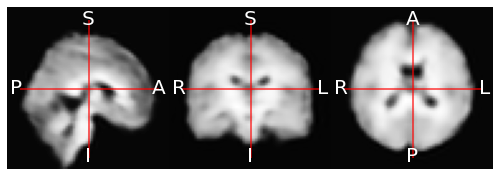

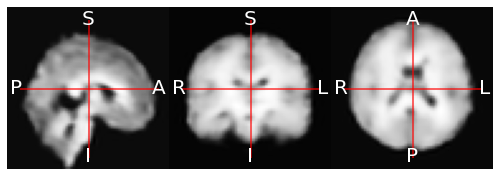

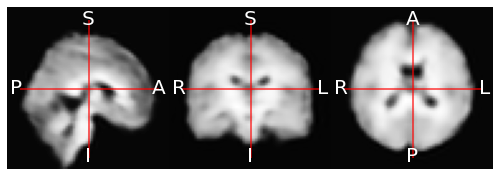

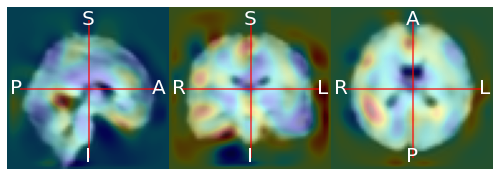

In [466]:
del_16p[0]['nii_td'].plot_ortho(flat=True)
del_16p[0]['nii_asd'].plot_ortho(flat=True)
del_16p[0]['nii_td'].plot_ortho(flat=True)

del_16p[0]['nii_td'].plot_ortho(del_16p[0]['J1'],flat=True,overlay_alpha=.3)

In [71]:
def plot_ortho(im,ol,i=32,j=32,k=32,clim=(None,None)):
    
    #i,j,k = 32,32,32
    vmin = clim[0];vmax = clim[1]
    im_ax = im.numpy()[:,:,k];im_ax = np.rot90(im_ax)
    im_cor = im.numpy()[:,j,:];im_cor = np.rot90(im_cor)
    im_sag = im.numpy()[i,:,:];im_sag = np.rot90(im_sag)

    ol_ax = ol.numpy()[:,:,k];ol_ax = np.rot90(ol_ax)
    ol_cor = ol.numpy()[:,j,:];ol_cor = np.rot90(ol_cor)
    ol_sag = ol.numpy()[i,:,:];ol_sag = np.rot90(ol_sag)

    ims = [im_ax,im_cor,im_sag]
    ols = [ol_ax,ol_cor,ol_sag]

    plt.figure(figsize=(15,5))
    for i in range(3):
        plt.subplot(1,3,i+1)
        plt.imshow(ims[i],cmap='gray')
        plt.imshow(ols[i],cmap='bwr',alpha=.3,vmin=vmin,vmax=vmax)
        #plt.imshow(ols[i],cmap='coolwarm',alpha=.3,vmin=vmin,vmax=vmax)
        cbar = plt.colorbar(shrink=.75);plt.xticks([]);plt.yticks([]);